In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


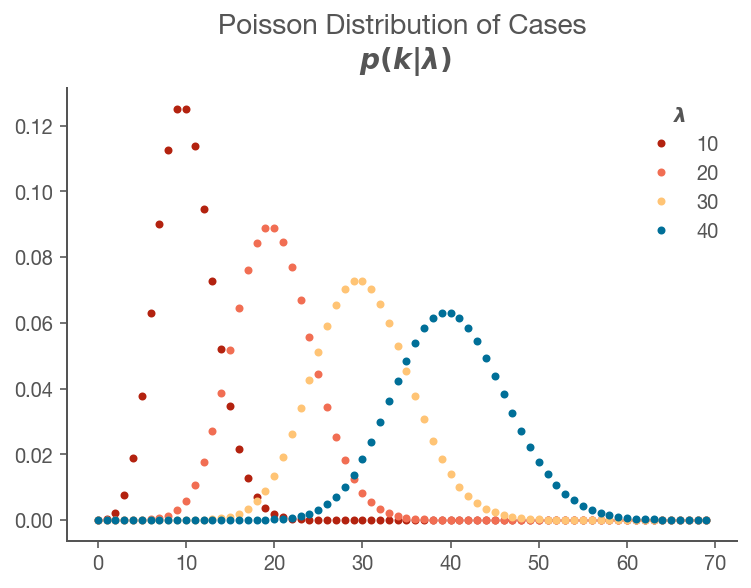

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

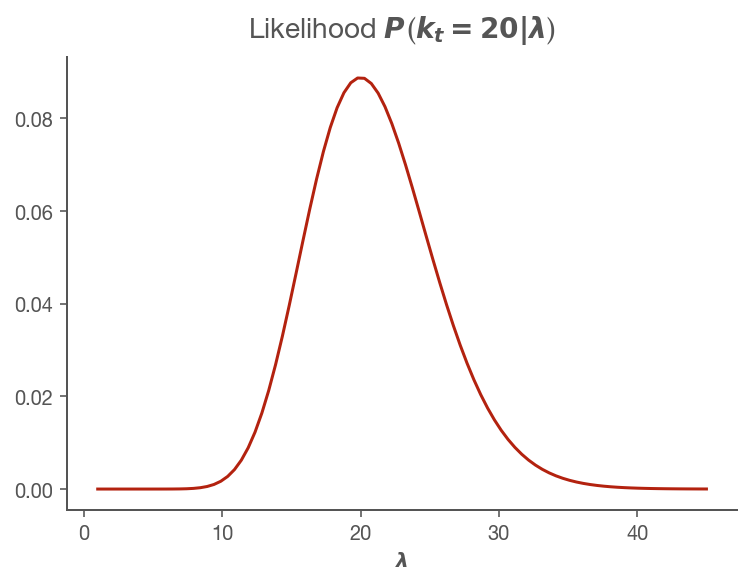

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$');

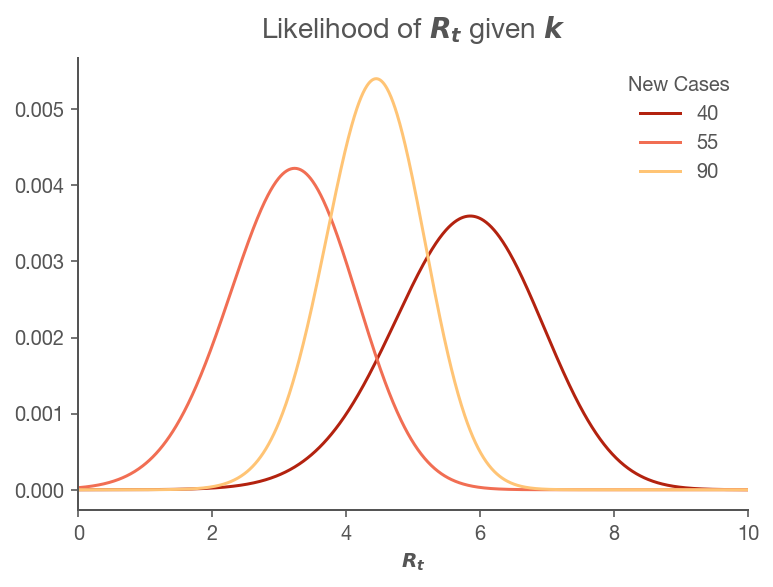

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

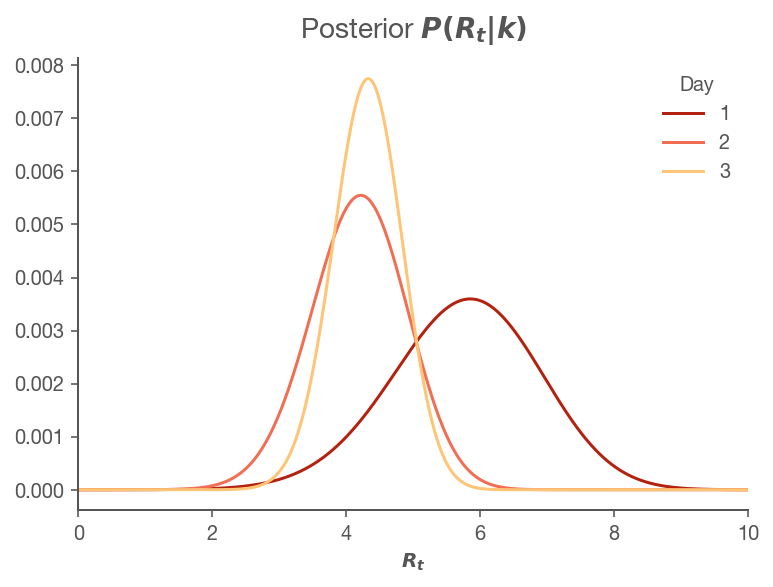

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [7]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

In [8]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()

,Low_90,High_90
Day,,
1,3.99,7.65
2,3.03,5.40
3,3.49,5.19


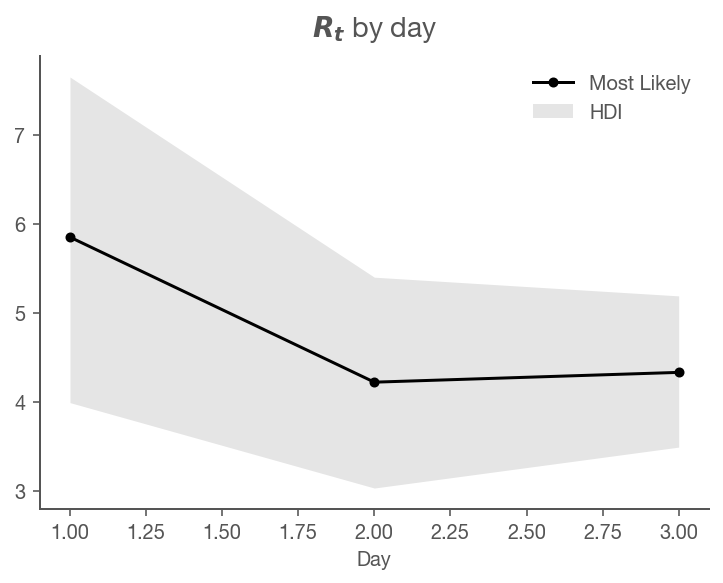

In [9]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

In [10]:
url = 'http://api.covid19india.org/states_daily_csv/confirmed.csv'
states_ind = pd.read_csv(url, 
                         encoding='UTF-8',
                         parse_dates=['date'],
                         index_col=['date']
                         )

#Array with info
data = states_ind.loc[:, ~states_ind.columns.str.contains('^Unnamed')] 

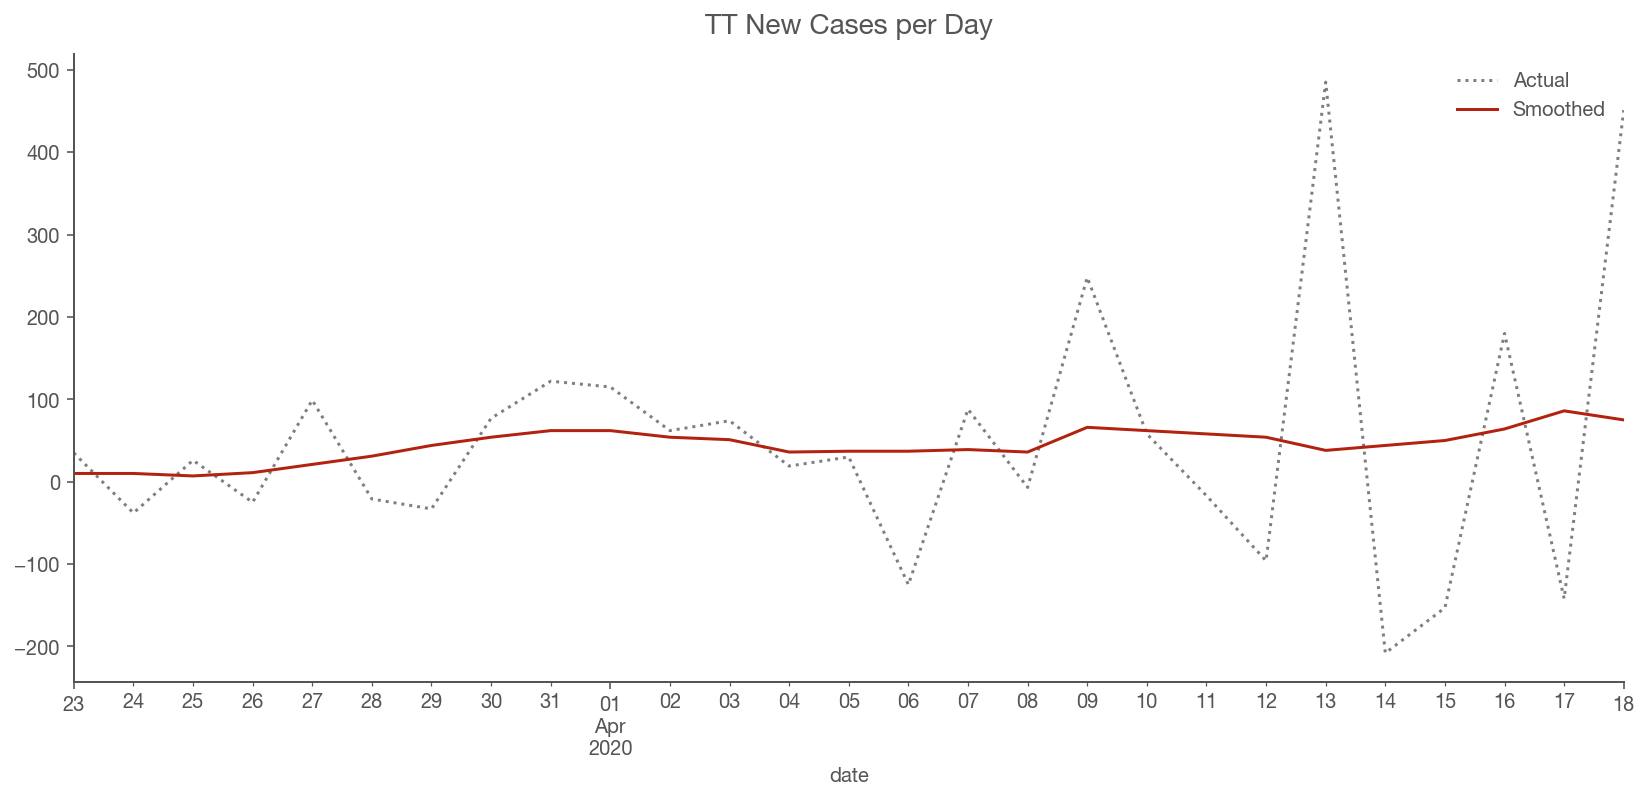

In [80]:
state_name = 'TT'
def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(9,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=3).round()
    
    idx_start = np.searchsorted(smoothed, 10)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = data[state_name]

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(1000/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [73]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.3)

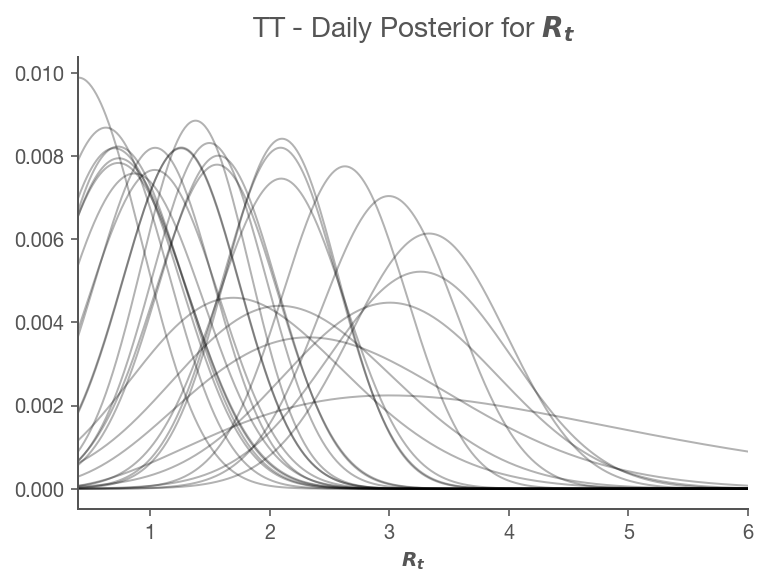

In [74]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [75]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-04-14,0.73,0.07,1.52
2020-04-15,1.04,0.25,1.88
2020-04-16,1.56,0.74,2.43
2020-04-17,2.10,1.32,2.88
2020-04-18,1.38,0.67,2.16


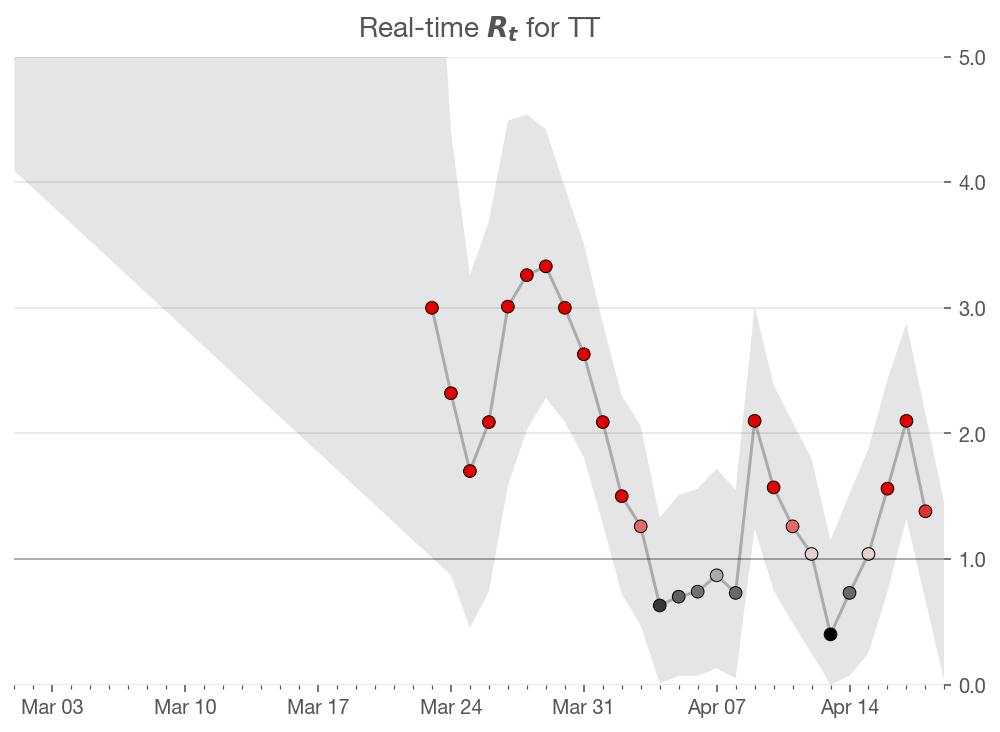

In [76]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [42]:
sigmas = np.linspace(1/20, 1, 20)

targets = ['MH','GJ']#data.keys() #need more data then change to this

results = {}

for state_name in targets:
    
    cases = data[state_name]
    print(state_name)
    new, smoothed = prepare_cases(cases)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

Done.


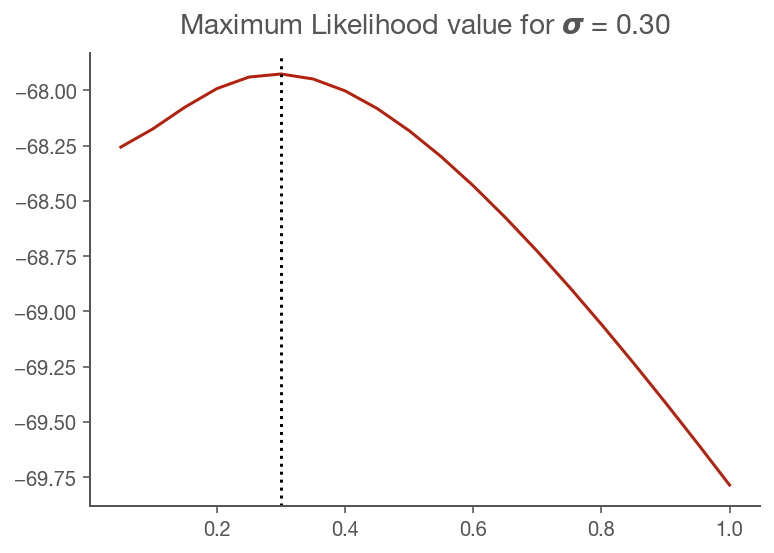

In [43]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

In [25]:
final_results = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    result['state'] = state_name
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

Done.


              ML  Low_90  High_90  Low_50  High_50 state
date                                                    
2020-04-12  3.00    1.01     6.99    2.04     4.45    GJ
2020-04-13  2.72    1.11     4.91    2.07     3.67    GJ
2020-04-14  3.14    1.54     4.88    2.56     3.96    GJ
2020-04-15  3.10    1.73     4.53    2.59     3.75    GJ
2020-04-16  3.15    1.96     4.36    2.71     3.70    GJ
2020-04-17  2.98    1.96     4.05    2.61     3.47    GJ
2020-04-18  2.67    1.73     3.60    2.33     3.10    GJ
              ML  Low_90  High_90  Low_50  High_50 state
date                                                    
2020-03-31  3.00    1.01     6.99    2.04     4.45    MH
2020-04-01  1.93    0.69     3.77    1.39     2.67    MH
2020-04-02  2.00    0.72     3.60    1.50     2.70    MH
2020-04-03  2.01    0.77     3.48    1.51     2.63    MH
2020-04-04  1.56    0.36     2.79    1.13     2.16    MH
2020-04-05  1.73    0.54     3.01    1.28     2.31    MH
2020-04-06  1.76    0.56     2.

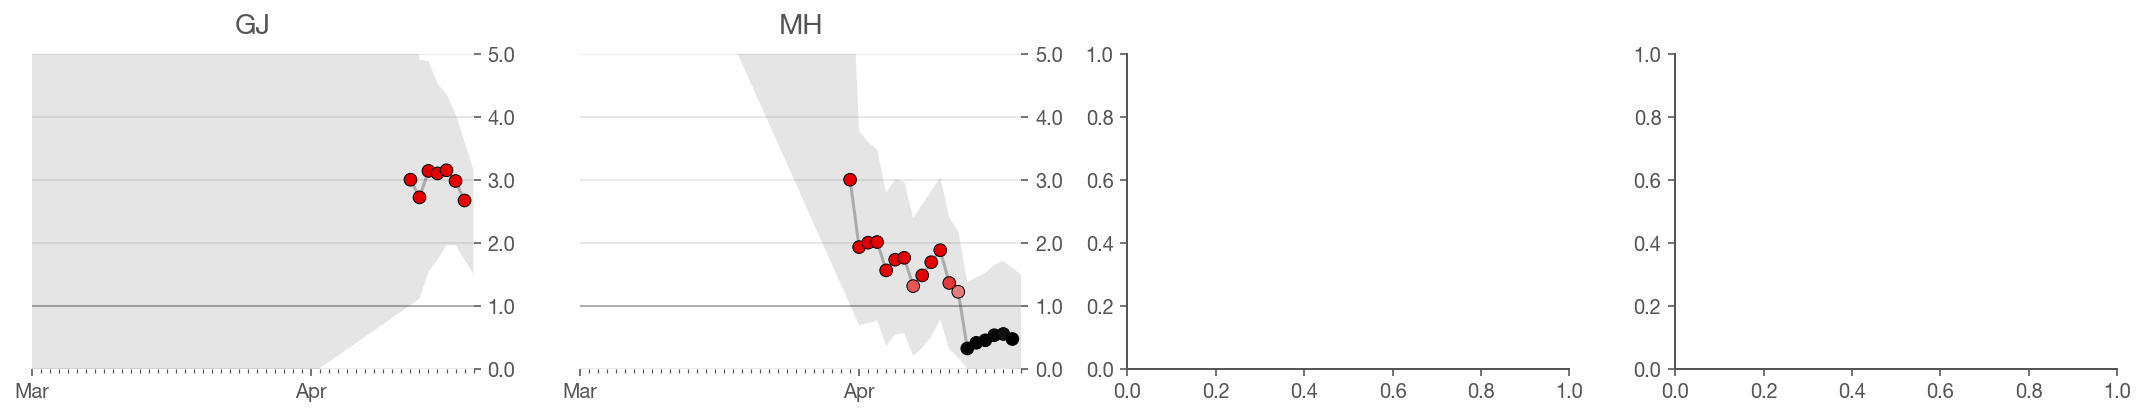

In [45]:
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

ValueError: Invalid RGBA argument: array([[4.53999298e-05, 2.06115362e-09, 9.35762297e-14, 4.24835426e-18],
       [4.53999298e-04, 4.12230724e-08, 2.80728689e-12, 1.69934170e-16],
       [2.26999649e-03, 4.12230724e-07, 4.21093034e-11, 3.39868340e-15],
       [7.56665496e-03, 2.74820483e-06, 4.21093034e-10, 4.53157787e-14],
       [1.89166374e-02, 1.37410241e-05, 3.15819775e-09, 4.53157787e-13],
       [3.78332748e-02, 5.49640966e-05, 1.89491865e-08, 3.62526230e-12],
       [6.30554580e-02, 1.83213655e-04, 9.47459326e-08, 2.41684153e-11],
       [9.00792257e-02, 5.23467587e-04, 4.06053997e-07, 1.38105230e-10],
       [1.12599032e-01, 1.30866897e-03, 1.52270249e-06, 6.90526152e-10],
       [1.25110036e-01, 2.90815326e-03, 5.07567496e-06, 3.06900512e-09],
       [1.25110036e-01, 5.81630652e-03, 1.52270249e-05, 1.22760205e-08],
       [1.13736396e-01, 1.05751028e-02, 4.15282497e-05, 4.46400745e-08],
       [9.47803301e-02, 1.76251713e-02, 1.03820624e-04, 1.48800248e-07],
       [7.29079462e-02, 2.71156481e-02, 2.39586056e-04, 4.57846918e-07],
       [5.20771044e-02, 3.87366401e-02, 5.13398691e-04, 1.30813405e-06],
       [3.47180696e-02, 5.16488535e-02, 1.02679738e-03, 3.48835747e-06],
       [2.16987935e-02, 6.45610669e-02, 1.92524509e-03, 8.72089367e-06],
       [1.27639962e-02, 7.59541964e-02, 3.39749134e-03, 2.05197498e-05],
       [7.09110899e-03, 8.43935515e-02, 5.66248556e-03, 4.55994440e-05],
       [3.73216263e-03, 8.88353174e-02, 8.94076668e-03, 9.59988295e-05],
       [1.86608131e-03, 8.88353174e-02, 1.34111500e-02, 1.91997659e-04],
       [8.88610150e-04, 8.46050642e-02, 1.91587857e-02, 3.65709827e-04],
       [4.03913704e-04, 7.69136947e-02, 2.61256169e-02, 6.64926958e-04],
       [1.75614654e-04, 6.68814737e-02, 3.40768916e-02, 1.15639471e-03],
       [7.31727725e-05, 5.57345614e-02, 4.25961145e-02, 1.92732452e-03],
       [2.92691090e-05, 4.45876491e-02, 5.11153374e-02, 3.08371922e-03],
       [1.12573496e-05, 3.42981916e-02, 5.89792355e-02, 4.74418342e-03],
       [4.16938875e-06, 2.54060679e-02, 6.55324839e-02, 7.02841988e-03],
       [1.48906741e-06, 1.81471913e-02, 7.02133756e-02, 1.00405998e-02],
       [5.13471521e-07, 1.25153044e-02, 7.26345265e-02, 1.38491032e-02],
       [1.71157174e-07, 8.34353625e-03, 7.26345265e-02, 1.84654710e-02],
       [5.52119915e-08, 5.38292661e-03, 7.02914772e-02, 2.38264141e-02],
       [1.72537473e-08, 3.36432913e-03, 6.58982599e-02, 2.97830177e-02],
       [5.22840828e-09, 2.03898735e-03, 5.99075090e-02, 3.61006275e-02],
       [1.53776714e-09, 1.19940432e-03, 5.28595668e-02, 4.24713265e-02],
       [4.39362041e-10, 6.85373900e-04, 4.53082001e-02, 4.85386588e-02],
       [1.22045011e-10, 3.80763278e-04, 3.77568334e-02, 5.39318431e-02],
       [3.29851382e-11, 2.05817988e-04, 3.06136487e-02, 5.83046953e-02],
       [8.68029952e-12, 1.08325257e-04, 2.41686700e-02, 6.13733634e-02],
       [2.22571783e-12, 5.55514138e-05, 1.85912846e-02, 6.29470394e-02],
       [5.56429457e-13, 2.77757069e-05, 1.39434635e-02, 6.29470394e-02],
       [1.35714502e-13, 1.35491253e-05, 1.02025343e-02, 6.14117458e-02],
       [3.23129766e-14, 6.45196443e-06, 7.28752447e-03, 5.84873769e-02],
       [7.51464571e-15, 3.00091369e-06, 5.08431940e-03, 5.44068623e-02],
       [1.70787403e-15, 1.36405168e-06, 3.46658141e-03, 4.94607839e-02],
       [3.79527561e-16, 6.06245190e-07, 2.31105427e-03, 4.39651412e-02],
       [8.25059916e-17, 2.63584865e-07, 1.50720931e-03, 3.82305576e-02],
       [1.75544663e-17, 1.12163772e-07, 9.62048494e-04, 3.25366448e-02],
       [3.65718048e-18, 4.67349052e-08, 6.01280309e-04, 2.71138706e-02],
       [7.46363363e-19, 1.90754715e-08, 3.68130801e-04, 2.21337719e-02],
       [1.49272673e-19, 7.63018860e-09, 2.20878481e-04, 1.77070176e-02],
       [2.92691515e-20, 2.99223082e-09, 1.29928518e-04, 1.38878569e-02],
       [5.62868298e-21, 1.15085801e-09, 7.49587604e-05, 1.06829668e-02],
       [1.06201566e-21, 4.34286041e-10, 4.24294870e-05, 8.06261649e-03],
       [1.96669566e-22, 1.60846682e-10, 2.35719372e-05, 5.97230851e-03],
       [3.57581029e-23, 5.84897025e-11, 1.28574203e-05, 4.34349710e-03],
       [6.38537552e-24, 2.08891795e-11, 6.88790374e-06, 3.10249793e-03],
       [1.12024132e-24, 7.32953665e-12, 3.62521249e-06, 2.17719153e-03],
       [1.93145055e-25, 2.52742643e-12, 1.87510991e-06, 1.50151140e-03],
       [3.27364500e-26, 8.56754723e-13, 9.53445717e-07, 1.01797383e-03],
       [5.45607500e-27, 2.85584908e-13, 4.76722859e-07, 6.78649220e-04],
       [8.94438525e-28, 9.36343959e-14, 2.34453865e-07, 4.45015882e-04],
       [1.44264278e-28, 3.02046438e-14, 1.13445419e-07, 2.87107021e-04],
       [2.28990918e-29, 9.58877582e-15, 5.40216279e-08, 1.82290172e-04],
       [3.57798309e-30, 2.99649245e-15, 2.53226381e-08, 1.13931357e-04],
       [5.50458937e-31, 9.21997675e-16, 1.16873714e-08, 7.01116045e-05],
       [8.34028692e-32, 2.79393235e-16, 5.31244155e-09, 4.24918815e-05],
       [1.24481894e-32, 8.34009657e-17, 2.37870517e-09, 2.53682875e-05],
       [1.83061609e-33, 2.45296958e-17, 1.04942875e-09, 1.49225220e-05],
       [2.65306680e-34, 7.11005675e-18, 4.56273371e-10, 8.65073742e-06]])

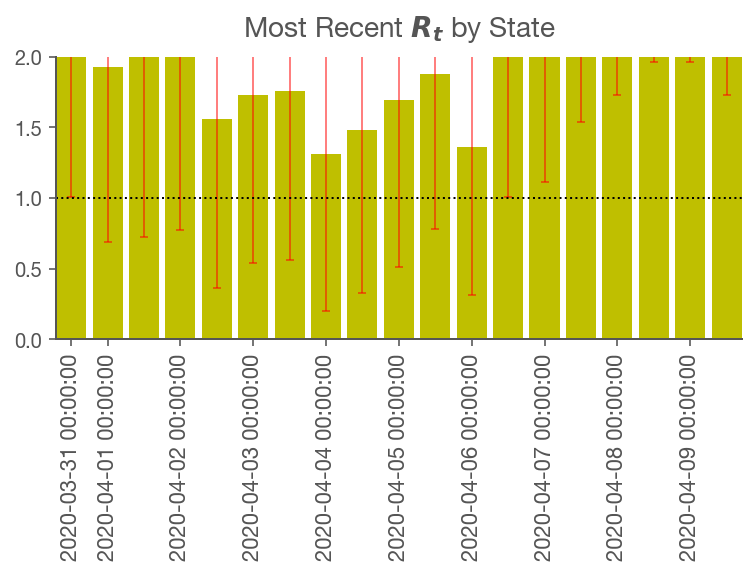

In [77]:
mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color='y',
                  ecolor='r',
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
    
    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=y),
                        Patch(label='None', color=w)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

plot_standings(mr);